In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from functools import partial
import jax.numpy as jnp

plt.rcParams['figure.figsize'] = [12, 8]

import time
from tqdm import tqdm

from sklearn.gaussian_process.kernels import ExpSineSquared


In [2]:
# Kernels for Kernel SOS
def gaussian_kernel(x, y, l=1.):
    return np.exp(-((x - y)**2).sum(-1) / l)

def make_kernels(X, Y, l=.1):
    
    n, dim = X.shape
    m = len(Y)
    kernel_func = gaussian_kernel
    K = kernel_func(X[:, None], Y, l)
    K += 1e-14 * np.eye(len(K)) # TODO: REVIEW. just to be sure with Cholesky
    Phi = np.linalg.cholesky(K).T

    return Phi, K



In [3]:
# logistic map

def logistic_map(r):
    def helper(x):
        return r * x * (1 - x)
    
    return helper

def bernoulli_map():
    def helper(x):
        if x < 0.5:
            return 2 * x
        else:
            return 2 * x - 1

    return helper

def gen_traj(curr_map, x0, N):

    x_curr = x0
    res = []
    for _ in range(N):
        res.append(x_curr)
        x_curr = curr_map(x_curr)

    res.append(x_curr)
    
    return res

In [64]:
def get_predict_func(k_func, X, Y):
    K_XX = k_func(X[:, None], X) + 1e-10 * np.eye(len(X)) # make_kernel_matrix(k_func, X, X)
    K_XXinv_Y = np.linalg.solve(K_XX, Y)
    
    
    def helper(x):
        K_Xx = np.empty(len(X))
        for i in range(len(X)):
            K_Xx[i] = k_func(x, X[i])
        return K_Xx.T @ K_XXinv_Y
        
    return helper

In [5]:
# @partial(jax.jit, static_argnames=['k_func'])
def make_kernel_matrix(k_func, X, Y):
    K_XY = np.empty(shape=(len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K_XY[i, j] = k_func(X[i], Y[j])
    return K_XY

In [15]:
def rho_comp(k_func, Xb, yb, Xc, yc):
    Kb = k_func(Xb[:, None], Xb) # make_kernel_matrix(k_func, Xb, Xb)
    Kb += 1e-10 * np.eye(len(Kb)) # TODO: REVIEW. just to be sure with Cholesky
    Kc = k_func(Xc[:, None], Xc) # make_kernel_matrix(k_func, Xc, Xc)
    Kc += 1e-10 * np.eye(len(Kc)) # TODO: REVIEW. just to be sure with Cholesky
    
    return 1 - (yb @ np.linalg.solve(Kb, yb))/(yc @ np.linalg.solve(Kc, yc))


def MMD_comp(k_func, X1, X2):
    res = 0
    m = len(X1)
    for i in range(m):
        for j in range(m):
            if i == j:
                continue
            res += k_func(X1[i], X1[j])
            res += k_func(X2[i], X2[j])
            res -= k_func(X1[i], X2[j])
            res -= k_func(X1[j], X2[i])
    return res / (m * (m - 1))
               
# learnable kernel 
def custom_kernel(theta):
    
    def kernel(x, y):
        c, d = theta
        xy_dot = (x * y).sum(-1)
        return (xy_dot + c)**d
    
    return kernel


def logistic_kernel(theta):
    a0, s1, s2, s3 = theta
    def helper(x, y):
        xy_norm_squared = ((x - y)**2).sum(-1)
        return a0 * np.exp(-s1 * np.sin(np.pi * s2 * xy_norm_squared**2)**2) * np.exp(-xy_norm_squared/(s3**2)) 
        
        
    return helper


In [7]:
# np.linalg.eigh(kernel(Xc.reshape(-1, 1), Xc.reshape(-1, 1)))

In [8]:
k_func = logistic_kernel([1, 1, 1, 1])
Kc = make_kernel_matrix(k_func, Xc, Xc) # k_func(Xc[:, None], Xc)
# Kc
# np.linalg.eigh(Kc)

NameError: name 'Xc' is not defined

In [9]:
import numpy as np

# Check the machine epsilon for float64
epsilon = np.finfo(np.float64).eps
print(f"Machine epsilon for float64: {epsilon}")

# Example to show the precision with an iterative process
def dyadic_transform(x):
    return (2 * x) % 1

def dyadic_transform_sequence(x0, n):
    x = x0
    sequence = np.zeros(n)
    for i in range(n):
        sequence[i] = x
        x = dyadic_transform(x)
    return sequence

# Initial value and number of iterations
x0 = 0.1
n = 100

# Generate and print the sequence
sequence = dyadic_transform_sequence(x0, n)
print(sequence)


Machine epsilon for float64: 2.220446049250313e-16
[0.1        0.2        0.4        0.8        0.6        0.2
 0.4        0.8        0.6        0.2        0.4        0.8
 0.6        0.2        0.4        0.8        0.6        0.2
 0.4        0.8        0.6        0.2        0.4        0.8
 0.6        0.2        0.4        0.8        0.6        0.2
 0.40000001 0.80000001 0.60000002 0.20000005 0.4000001  0.80000019
 0.60000038 0.20000076 0.40000153 0.80000305 0.6000061  0.20001221
 0.40002441 0.80004883 0.60009766 0.20019531 0.40039062 0.80078125
 0.6015625  0.203125   0.40625    0.8125     0.625      0.25
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        

In [477]:
import numpy as np
from decimal import Decimal, getcontext

# Set the precision higher than the default 28
getcontext().prec = 50

def dyadic_transform_decimal(x):
    """
    Apply the Dyadic transformation using Decimal for higher precision.
    
    Parameters:
    x (Decimal): The input value (should be in the interval [0, 1)).
    
    Returns:
    Decimal: The result of the Dyadic transformation applied to x.
    """
    return (2 * x) % 1

def dyadic_transform_sequence_decimal(x0, n):
    """
    Generate a sequence of values using the Dyadic transformation with Decimal.
    
    Parameters:
    x0 (float): The initial value (should be in the interval [0, 1)).
    n (int): The number of iterations to perform.
    
    Returns:
    np.ndarray: An array of n values representing the Dyadic transformation sequence.
    """
    x = Decimal(x0)
    sequence = np.zeros(n, dtype=object)
    for i in range(n):
        sequence[i] = float(x)
        x = dyadic_transform_decimal(x)
    return sequence

# Example usage
x0 = 0.1  # Initial value
n = 100   # Number of iterations

sequence = dyadic_transform_sequence_decimal(x0, n)
print(sequence)


[0.1 0.2 0.4 0.8 0.6000000000000001 0.20000000000000018
 0.40000000000000036 0.8000000000000007 0.6000000000000014
 0.20000000000000284 0.4000000000000057 0.8000000000000114
 0.6000000000000227 0.20000000000004547 0.40000000000009095
 0.8000000000001819 0.6000000000003638 0.2000000000007276
 0.4000000000014552 0.8000000000029104 0.6000000000058208
 0.20000000001164153 0.40000000002328306 0.8000000000465661
 0.6000000000931323 0.20000000018626451 0.40000000037252903
 0.8000000007450581 0.6000000014901161 0.20000000298023224
 0.4000000059604645 0.800000011920929 0.6000000238418579
 0.20000004768371582 0.40000009536743164 0.8000001907348633
 0.6000003814697266 0.20000076293945312 0.40000152587890625
 0.8000030517578125 0.600006103515625 0.20001220703125 0.4000244140625
 0.800048828125 0.60009765625 0.2001953125 0.400390625 0.80078125
 0.6015625 0.203125 0.40625 0.8125 0.625 0.25 0.5 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1

In [484]:
import mpmath

# Set the precision to a higher value
mpmath.mp.dps = 100  # Decimal places of precision

def dyadic_transform_mpmath(x):
    """
    Apply the Dyadic transformation using mpmath for higher precision.
    
    Parameters:
    x (mpmath.mpf): The input value (should be in the interval [0, 1)).
    
    Returns:
    mpmath.mpf: The result of the Dyadic transformation applied to x.
    """
    return 2 * x % 1 # mpmath.fmod(2 * x, 1)

def dyadic_transform_sequence_mpmath(x0, n):
    """
    Generate a sequence of values using the Dyadic transformation with mpmath.
    
    Parameters:
    x0 (float or str): The initial value (should be in the interval [0, 1)).
    n (int): The number of iterations to perform.
    
    Returns:
    list: A list of n values representing the Dyadic transformation sequence.
    """
    x = x0 # mpmath.mpf(x0)
    sequence = []
    for _ in range(n):
        sequence.append(x)
        x = dyadic_transform_mpmath(x)
    return sequence

# Example usage
x0 = np.pi / 10 # 0.1 #'0.1'  # Initial value as a string for high precision
n = 100     # Number of iterations

sequence = dyadic_transform_sequence_mpmath(x0, n)

# Convert the sequence to floats for display purposes
sequence_floats = [float(x) for x in sequence]
print(sequence_floats)


[0.3141592653589793, 0.6283185307179586, 0.25663706143591725, 0.5132741228718345, 0.026548245743668986, 0.05309649148733797, 0.10619298297467594, 0.21238596594935188, 0.42477193189870377, 0.8495438637974075, 0.6990877275948151, 0.39817545518963016, 0.7963509103792603, 0.5927018207585206, 0.18540364151704125, 0.3708072830340825, 0.741614566068165, 0.48322913213633, 0.96645826427266, 0.93291652854532, 0.8658330570906401, 0.7316661141812801, 0.46333222836256027, 0.9266644567251205, 0.8533289134502411, 0.7066578269004822, 0.41331565380096436, 0.8266313076019287, 0.6532626152038574, 0.30652523040771484, 0.6130504608154297, 0.22610092163085938, 0.45220184326171875, 0.9044036865234375, 0.808807373046875, 0.61761474609375, 0.2352294921875, 0.470458984375, 0.94091796875, 0.8818359375, 0.763671875, 0.52734375, 0.0546875, 0.109375, 0.21875, 0.4375, 0.875, 0.75, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [10]:
def lorentz_map(s=10, r=28, b=10/3.):
    
    def helper(x_vec):
        h = 0.01
        x, y, z = x_vec
        x1 = x + h * (s * (y - x))
        y1 = y + h * (r * x - y - x * z)
        z1 = z + h * (x * y - b * z)
        return [x1, y1, z1]
        
    return helper

In [26]:
def K_lorentz_one(theta):
    a0, a1, b, a2, s = theta
    def helper(x, y):
        xy_norm_squared = ((x - y)**2).sum(-1)
        return a0 + (a1 + np.sqrt(xy_norm_squared))**b + a2 * np.exp(-xy_norm_squared/s**2)
    return helper

In [13]:
x_vec_0 = [0, 1, 1.05]
# x_vec_0 = [0.5, 1.5, 2.5]

traj = np.array(gen_traj(lorentz_map(), x_vec_0, 10000))

In [92]:
thetas = [[1, 0.95, 2.02, 0.94, 1.08],
         [1, 1.02, 1.79, 0.98, 1.0],
         [1, 0.99, 1.9, 0.99, 1.0]]

# thetas = [[0, 0, 0, 1, 1.0],
#          [0, 0, 0, 1, 1.0],
#          [0, 0,0, 1, 1.0]]

In [93]:
def predict_series_3d(x0, pred_funcs, N):
    traj = np.empty(shape=(N + 1, 3))
    traj[0, :] = x0
    for i in range(1, N):
        for k in range(3):
            traj[i, k] = pred_funcs[k](traj[i - 1])
    return traj
    

In [94]:
x0 = [0, 1, 1.05]
N = 10000

traj_train = np.array(gen_traj(lorentz_map(), x_vec_0, 10000))

N_sub = 500
idxs = np.random.choice(len(traj_train), N_sub)
X = traj_train[idxs]
Y = np.array([lorentz_map()(x) for x in X])

In [95]:
X.shape

(500, 3)

In [96]:
pred_funcs = [get_predict_func(K_lorentz_one(thetas[i]), X, Y[:, i]) for i in range(3)]

In [97]:
x0 = [0.5, 1.5, 2.5]

N_fore = 500
pred_vals = predict_series_3d(x0, pred_funcs, N_fore)
true_vals = np.array(gen_traj(lorentz_map(), x0, N_fore))

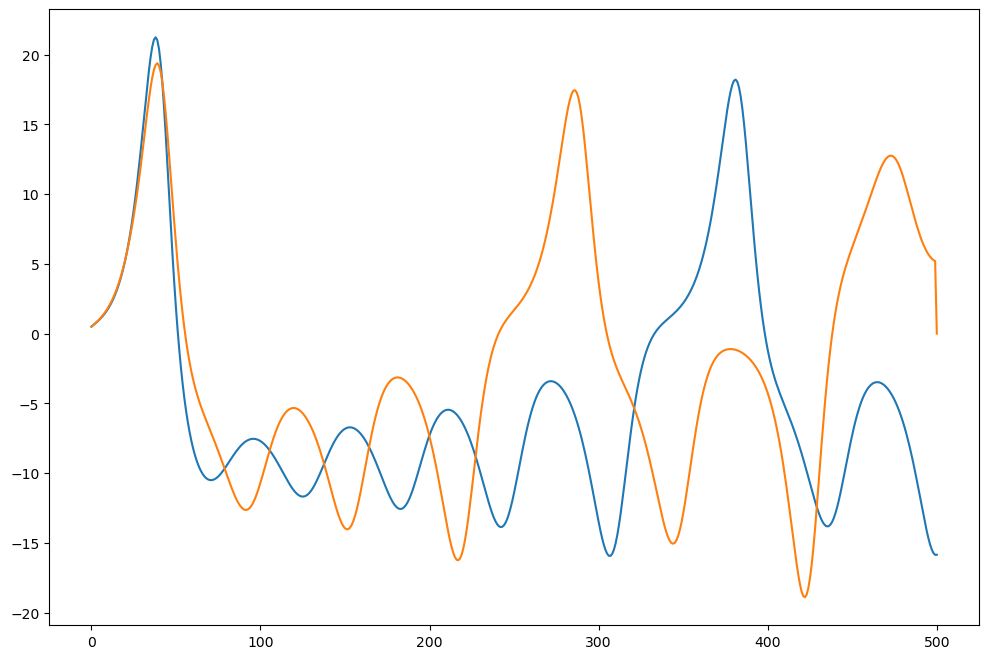

In [98]:
plt.plot(true_vals[:, 0])
plt.plot(pred_vals[:, 0])

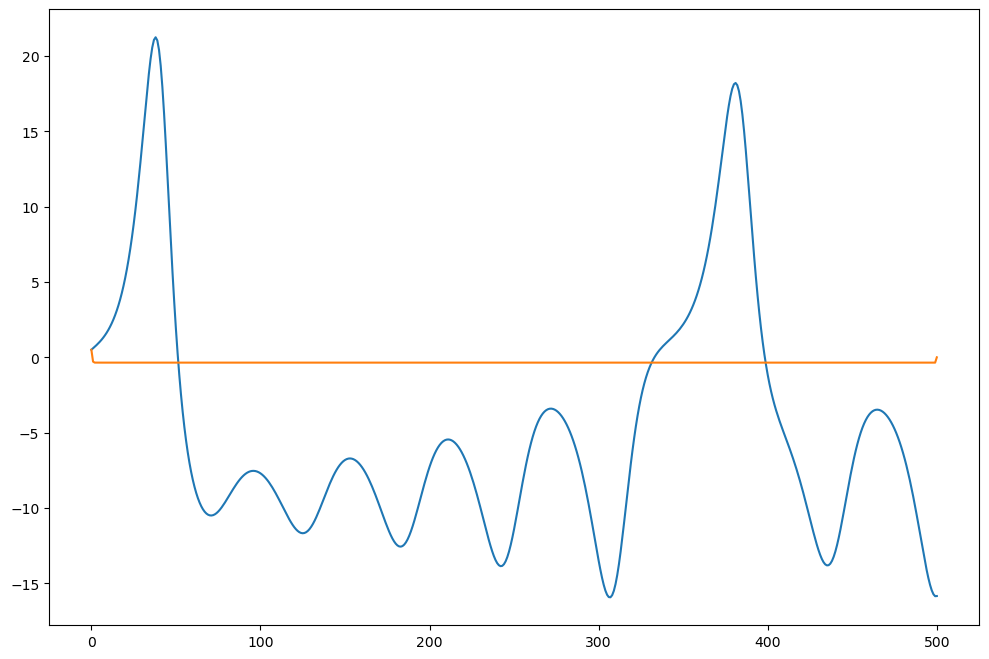

In [91]:
plt.plot(true_vals[:, 0])
plt.plot(pred_vals[:, 0])

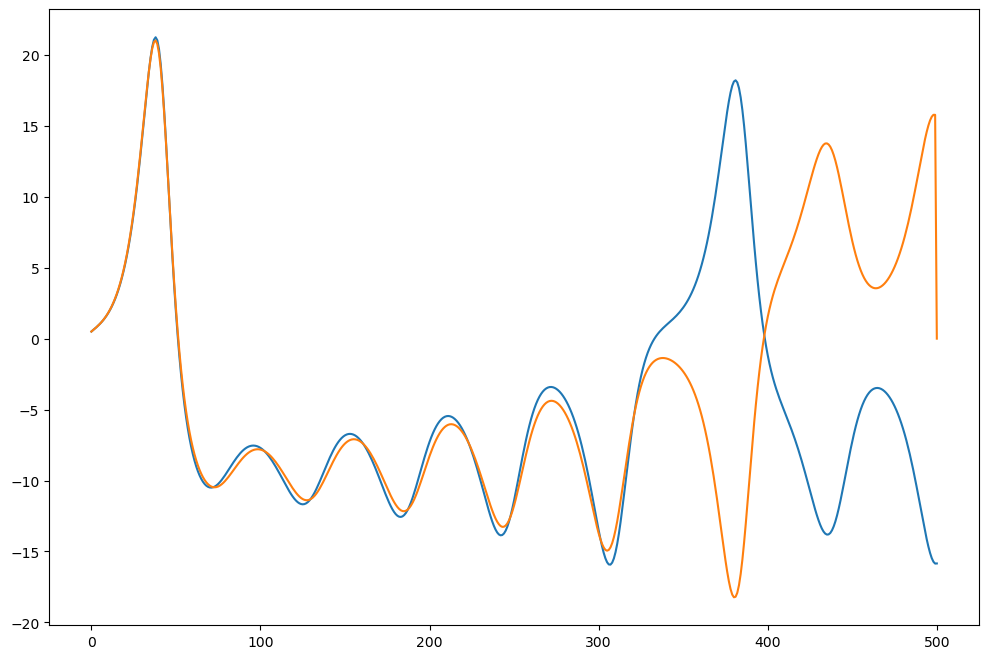

In [83]:
plt.plot(true_vals[:, 0])
plt.plot(pred_vals[:, 0])

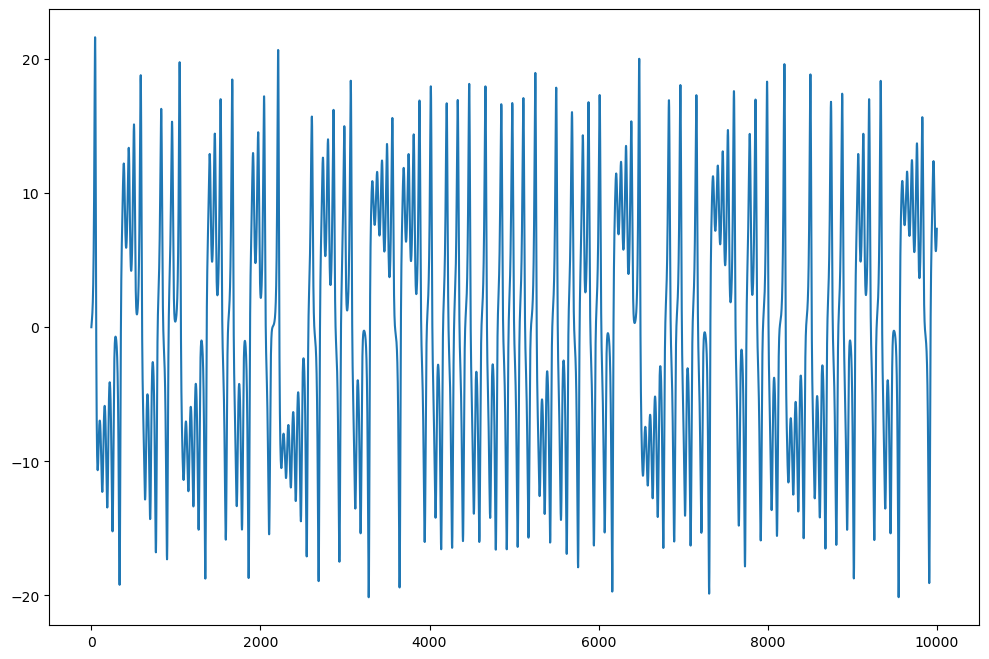

In [14]:
plt.plot(traj[:, 0])


In [473]:
new_traj[:50]


array([0.44879895, 0.8975979 , 0.7951958 , 0.5903916 , 0.18078321,
       0.36156642, 0.72313283, 0.44626567, 0.89253133, 0.78506266,
       0.57012533, 0.14025065, 0.2805013 , 0.5610026 , 0.1220052 ,
       0.2440104 , 0.48802081, 0.97604162, 0.95208323, 0.90416647,
       0.80833294, 0.61666588, 0.23333175, 0.46666351, 0.93332702,
       0.86665404, 0.73330808, 0.46661615, 0.93323231, 0.86646461,
       0.73292923, 0.46585846, 0.93171692, 0.86343384, 0.72686768,
       0.45373535, 0.9074707 , 0.81494141, 0.62988281, 0.25976562,
       0.51953125, 0.0390625 , 0.078125  , 0.15625   , 0.3125    ,
       0.625     , 0.25      , 0.5       , 0.        , 0.        ])

In [468]:
new_traj


array([0.31415927, 0.62831853, 0.25663706, 0.51327412, 0.02654825,
       0.05309649, 0.10619298, 0.21238597, 0.42477193, 0.84954386,
       0.69908773, 0.39817546, 0.79635091, 0.59270182, 0.18540364,
       0.37080728, 0.74161457, 0.48322913, 0.96645826, 0.93291653,
       0.86583306, 0.73166611, 0.46333223, 0.92666446, 0.85332891,
       0.70665783, 0.41331565, 0.82663131, 0.65326262, 0.30652523,
       0.61305046, 0.22610092, 0.45220184, 0.90440369, 0.80880737,
       0.61761475, 0.23522949, 0.47045898, 0.94091797, 0.88183594,
       0.76367188, 0.52734375, 0.0546875 , 0.109375  , 0.21875   ,
       0.4375    , 0.875     , 0.75      , 0.5       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

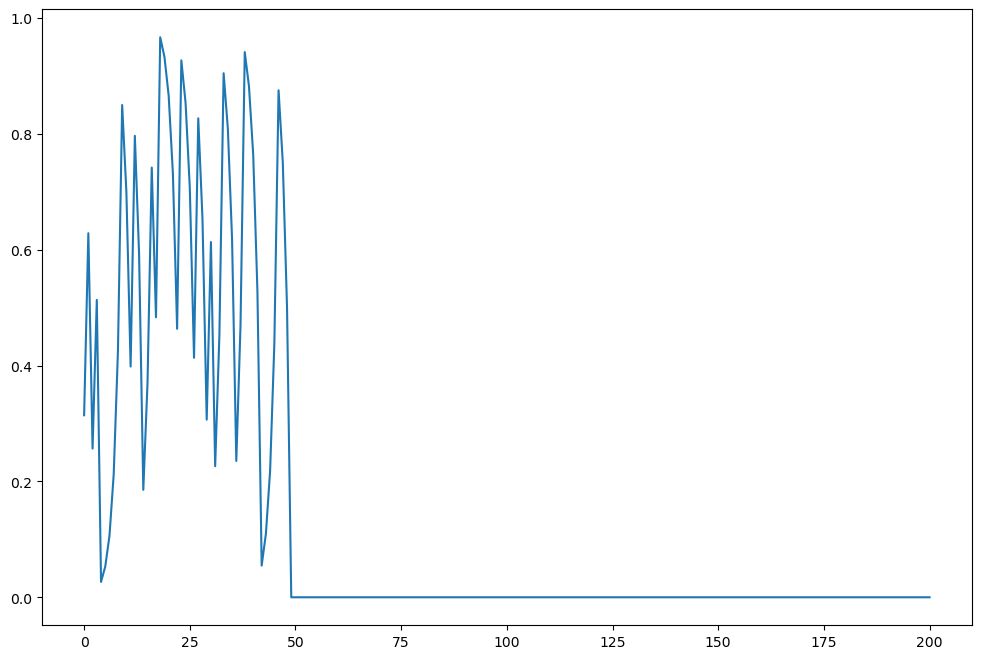

In [486]:
new_traj = np.array(gen_traj(bernoulli_map(), np.pi/10, N))
plt.plot(new_traj)

In [463]:
a = [3.141592653589793234587432678]

In [464]:
a[0]

3.141592653589793

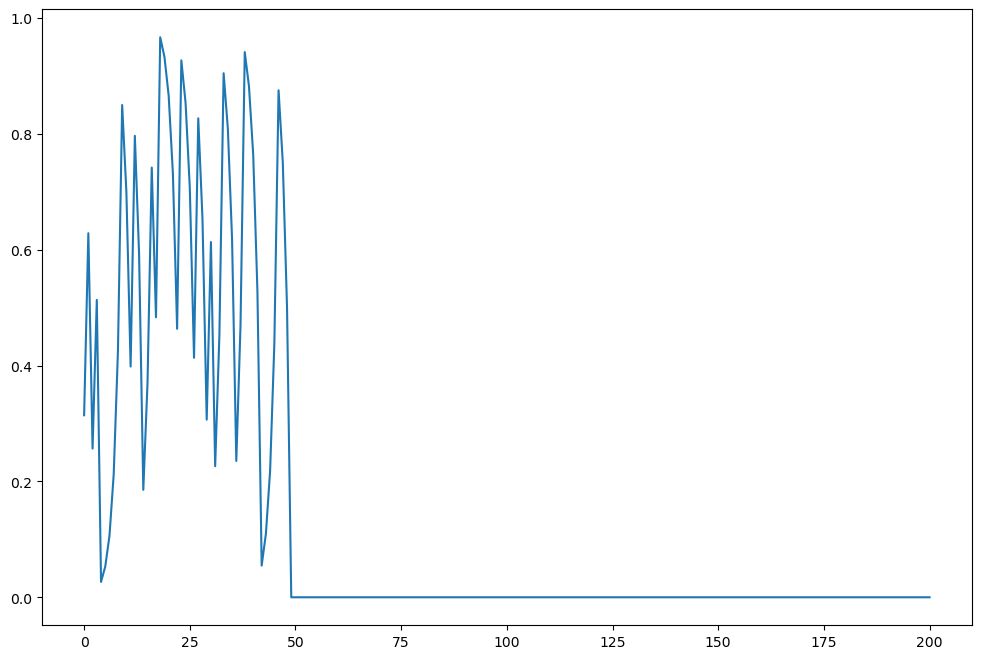

In [460]:
new_traj = np.array(gen_traj(bernoulli_map(), 3.141592653589793234587432678 / 10, N))
plt.plot(new_traj)

In [458]:
np.pi

3.141592653589793

In [338]:
theta_star

array([1.0132006 , 1.16508292, 1.14751006, 0.80363611])

In [384]:
theta_star = [0.95, 0.98, 1.20, 0.62]

k_func = logistic_kernel(theta_star)
predict_f = get_predict_func(k_func, X.reshape(-1, 1), Y.reshape(-1, 1))

In [385]:
X[0]

0.1

/var/folders/c5/jntdg8g94vld91_h2df0psfc0000gn/T/ipykernel_2383/2943646320.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_traj[i] =  predict_f(pred_traj.reshape(-1, 1)[i - 1])


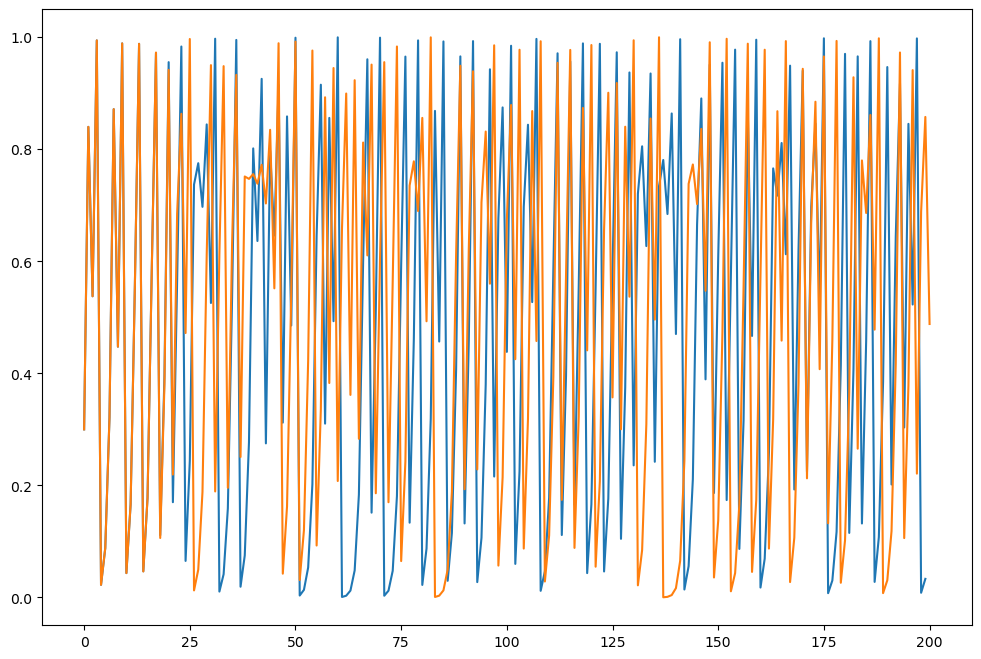

In [388]:
pred_traj = np.empty(N)
pred_traj[0] = 0.3
# for i in range(len(X)):
#     pred_traj[i] = predict_f(X.reshape(-1, 1)[i])

for i in range(1, len(pred_traj)):
    pred_traj[i] =  predict_f(pred_traj.reshape(-1, 1)[i - 1])
    
plt.plot(pred_traj)
plt.plot(new_traj)
# plt.xlim(200, 250)

In [336]:

k_func = logistic_kernel(theta_star)
make_kernel_matrix(k_func, X.reshape(-1, 1), X.reshape(-1, 1)).shape
predict_f = get_predict_func(k_func, X.reshape(-1, 1), Y.reshape(-1, 1))
# print(predict_f(traj[-1].reshape(1)))


# print(logistic_map(4)(traj[-1]))


In [279]:
# Get the loss as a function of Theta
def get_loss(Xb, yb, Xc, yc, loss_type="MMD"):
    
    def helper(theta):
        k_func = logistic_kernel(theta) # custom_kernel(theta)
        if loss_type == "MMD":
            return MMD_comp(k_func, Xb, Xc)
        else:
            return rho_comp(k_func, Xb, yb, Xc, yc)
        
    return helper

In [280]:
# Hessian and Gradient for the Optimization Algorithm
def get_Hgrad(alpha, fs, Phi, lmbda, eps):
    n = len(fs)
    grad = np.empty(n)
    pre_inv_term = Phi @ np.diag(alpha) @ Phi.T + lmbda * np.eye(n)
    for i in range(n):
        
        grad[i] = fs[i] - eps/n * Phi[:, i].T @ np.linalg.solve(pre_inv_term, Phi[:, i])
    return grad

def get_Hhess(alpha, fs, Phi, lmbda, eps):
    n = len(fs)
    hess = np.empty(shape=(n, n))
    pre_inv_term = Phi @ np.diag(alpha) @ Phi.T + lmbda * np.eye(n)
    for i in range(n):
        for j in range(n):
            hess[i, j] = eps/n * (Phi[:, i].T @ np.linalg.solve(pre_inv_term, Phi[:, j]))**2
    return hess

In [383]:
# Get the Dataset 
r = 4
x0 = 0.1
N = 200
traj = np.array(gen_traj(r, x0, N))
X = traj[:-1]
Y = traj[1:]

N_sub = 100

b_idxs = np.random.choice(len(X), N_sub)
c_idxs = None # np.random.choice(len(X), N_sub)
Xb = X[b_idxs].reshape(-1, 1)
yb = Y[b_idxs]

if c_idxs is None:
    Xc = X.reshape(-1, 1)
    yc = Y
else:
    Xc = X[c_idxs].reshape(-1, 1)
    yc = Y[c_idxs]


In [358]:
def sample_uniform(N, low_b, up_b, r):
    mid_val = (up_b + low_b)/2.
    length = (up_b - low_b) * r
    
    pts = (np.random.uniform(size=N) - 1/2.) * length + mid_val
    return pts

def sample_points(bounds, N, r=1):
    return np.array([sample_uniform(N, b[0], b[1], r) for b in bounds]).T #sample_uniform(N, -1, 1, r) # func_utils.get_points(np.zeros(self.d), N, fixed_bound=r*5)


In [359]:
thetas.shape

thetas = sample_points([[0.5, 1.5]] * 4, 100)


In [360]:
k_func = logistic_kernel([1, 1, 1, 1])
# k_func = logistic_kernel(thetas[0])

In [322]:
# Kc = make_kernel_matrix(k_func, Xc, Xc) # k_func(Xc[:, None], Xc)
# np.linalg.eigh(Kc)

In [324]:
# def rho_comp(k_func, Xb, yb, Xc, yc):
#     Kb = k_func(Xb[:, None], Xb) # make_kernel_matrix(k_func, Xb, Xb)
#     Kb += 1e-10 * np.eye(len(Kb)) # TODO: REVIEW. just to be sure with Cholesky
#     Kc = k_func(Xc[:, None], Xc) # make_kernel_matrix(k_func, Xc, Xc)
#     Kc += 1e-10 * np.eye(len(Kc)) # TODO: REVIEW. just to be sure with Cholesky
    
    
#     return 1 - (yb @ np.linalg.solve(Kb, yb))/(yc @ np.linalg.solve(Kc, yc))

# Setup for Kernel SOS. 
loss = get_loss(Xb, yb, Xc, yc, "rho")

# # Sample parameters and get function values
# cs = np.linspace(0, 4, 10)
# ds = np.linspace(0.1, 3, 10)

# XY = np.meshgrid(cs, ds)
# thetas = np.vstack([xy.flatten() for xy in XY]).T


fs = [loss(t) for t in tqdm(thetas)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6384.80it/s]


In [325]:
# Initial Alpha

alpha = np.ones(len(fs)) # np.linspace(1, 10, len(fs))
alpha /= np.sum(alpha)
alpha

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [326]:
# Optimization Algorithm
Phi, K = make_kernels(thetas, thetas)
for _ in range(20):

    lmbda = 0.0001
    eps = 0.1
    n = len(alpha)

    hess = get_Hhess(alpha, fs, Phi, lmbda, eps)
    grad = get_Hgrad(alpha, fs, Phi, lmbda, eps)
    

    Hinv_grad = np.linalg.solve(hess, grad)
    Hinv_one = np.linalg.solve(hess, np.ones(n))
    delta = Hinv_grad - np.ones(n).T @ Hinv_grad / (np.ones(n).T @ Hinv_one) * Hinv_one
    newt_dec = delta.T @ hess @ delta
    print(newt_dec)
    alpha = alpha - 1/(1 + np.sqrt(n/ eps) * np.sqrt(newt_dec)) * delta

0.07837300370870638
0.06251145114729767
0.05024925664490536
0.040297019934975954
0.031881709270948855
0.02454946647799909
0.018095578132070318
0.012510921423162326
0.00790490653961875
0.004403628466329354
0.0020442816829266347
0.0007135812445599532
0.00015206515568034687
1.254991140444908e-05
1.4329021248268764e-07
2.5159873585723953e-11
8.869452079937305e-19
2.6692434130707487e-31
5.591705742723587e-32
2.868840344755714e-32


In [327]:
alpha

array([0.00865315, 0.00488616, 0.0032425 , 0.00378921, 0.00428082,
       0.0086845 , 0.00299509, 0.00822179, 0.00669627, 0.11096909,
       0.03601723, 0.00441828, 0.00506789, 0.00272824, 0.00513763,
       0.00633977, 0.00561263, 0.00253664, 0.00448456, 0.00858485,
       0.0065296 , 0.00593031, 0.00290942, 0.00476143, 0.00365231,
       0.00385378, 0.01413935, 0.00253355, 0.00303506, 0.00475785,
       0.00406471, 0.00241418, 0.01001996, 0.00484678, 0.00525888,
       0.01510932, 0.00400743, 0.04070013, 0.0039061 , 0.00465067,
       0.01599435, 0.00273141, 0.00404974, 0.01261929, 0.00920185,
       0.00582693, 0.00750783, 0.00533196, 0.00353653, 0.00384655,
       0.00721515, 0.00536676, 0.00482003, 0.00488992, 0.00511521,
       0.00648504, 0.00246523, 0.00731281, 0.00572829, 0.00603609,
       0.00431395, 0.0023133 , 0.0109666 , 0.00338577, 0.00430381,
       0.00327367, 0.0078695 , 0.00402588, 0.0049412 , 0.0135934 ,
       0.00706724, 0.01015225, 0.00189243, 0.00397439, 0.00606

In [328]:
theta_star = thetas.T @ alpha

In [ ]:
# Kernel flow optimization




# General Plots

In [19]:
r = 4
x0 = 0.1
N = 100
traj = np.array(gen_traj(r, x0, N))

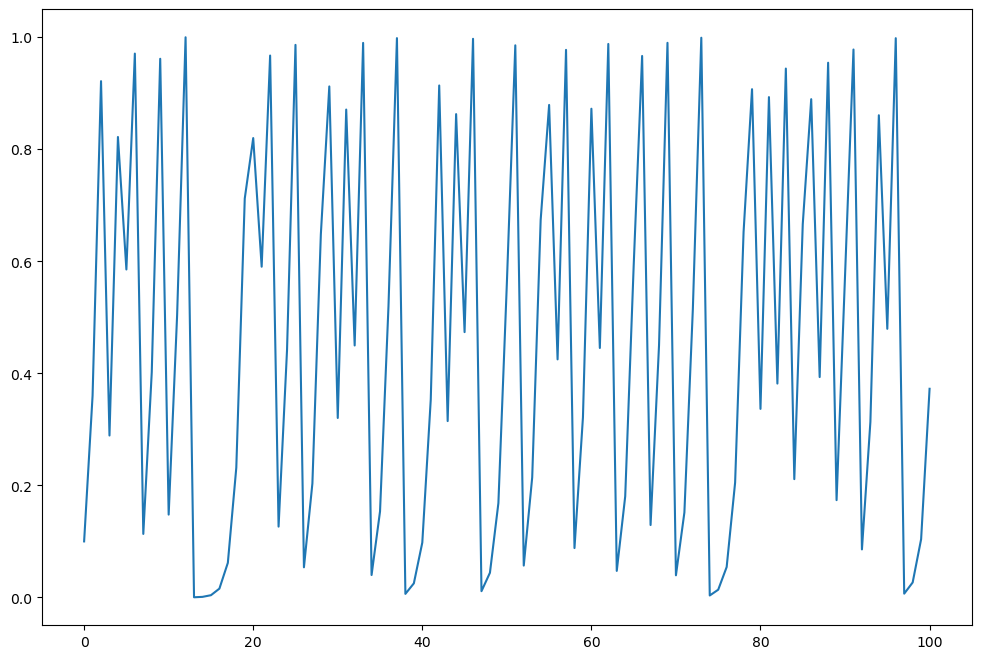

In [20]:
plt.plot(traj)

In [9]:
# bifurcations
N_init = 20
N_rs = 100

init_conds = np.linspace(0, 1, N_init)

rs = np.linspace(0, 4, N_rs)
maps = [logistic_map(r) for r in rs]

N_iters = 100

res = np.empty((N_iters, N_init, N_rs))


for i in range(N_iters):
    for j in range(N_init):
        for k in range(N_rs):
            if i == 0:
                res[i, j, k] = init_conds[j]
            else:
                res[i, j, k] = maps[k](res[i - 1, j, k])
                

               
        
        


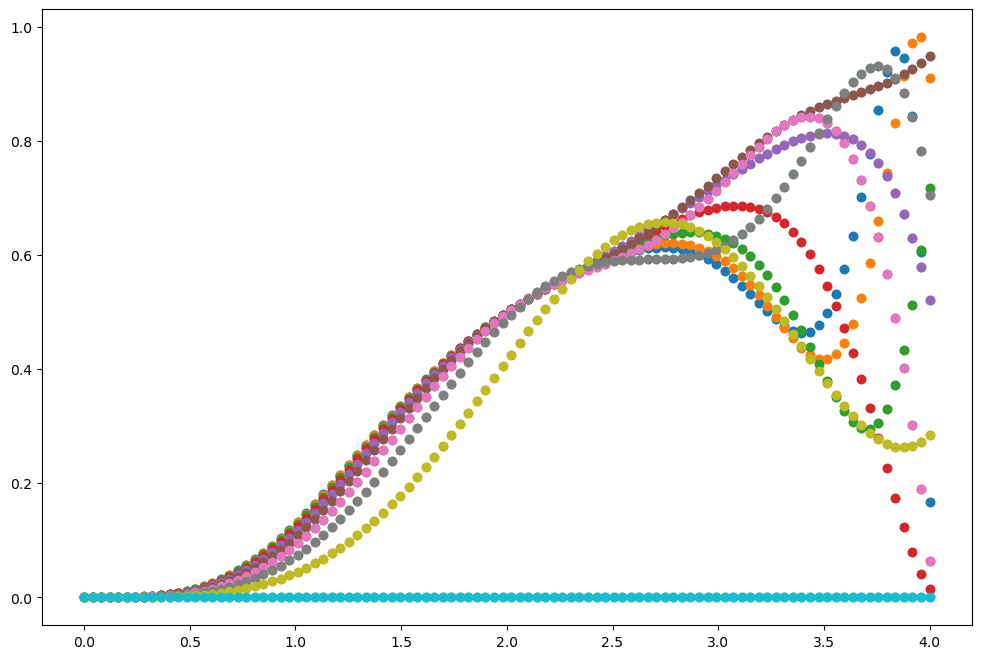

In [10]:
n_iter = 4

for j in range(N_init):
    plt.scatter(rs, res[n_iter, j, :])